# Multi-energy generation systems - General formulation

This is the first document in a series of jupyter notebooks which presents a general formulation of a centralised multi-energy system (MES). The models presented here are based on the following literature:

- E. A. Martínez Ceseña, T. Capuder and P. Mancarella, “[Flexible distributed multi-energy generation system expansion planning under uncertainty](https://ieeexplore.ieee.org/document/7064771),” IEEE Transactions on Smart Grid, vol. 7, no. 1, pp. 348 –357, 2016.


- T. Capuder, P. Mancarella, "[Techno-economic and environmental modelling and optimization of flexible distributed multi-generation options](https://www.sciencedirect.com/science/article/pii/S0360544214005283)," Energy, vol. 71, pp. 516-533, 2014.

This notebook provides the basic MES system with electricity, heat and gas demand, which imports electricity from the power grid and uses a gas bolir to supply its heat demand.

To do the examples below, you will need a basic understanding ot mathematical programming formuolations. It would also be useful to have a basic understanding of the [pyomo](https://pyomo.readthedocs.io/en/stable/tutorial_examples.html) python library, which is the one used to solve the examples.

**Note that the model below was developed using python's pyomo but, as shown in the references, the formulation is general and can be developed with other software**

Before beginning, and optimisation mathematical programming model (in `pyomo`) has to be defined. In this notebook, the pyomo object is named `pyo`, whereas the mathematical programming model is named`model`.

In [1]:
import pyomo.environ as pyo
model = pyo.ConcreteModel()

## List of contents

- [Considerations to generalize the MES model](#Considerations-to-generalize-the-MES-model)
- [General DER model](#General-DER-model)
  - [Modelling conversion devices using energy hubs](#Modelling-conversion-devices-using-energy-hubs)
  - [Modelling storage devices](#Modelling-storage-devices)
  - [Adding DER variables and constraints](#Adding-DER-variables-and-constraints)
- [General energy balance model](#General-energy-balance-model)
  - [Limiting use of vectors](#Limiting-use-of-vectors)
  - [Connections between networks and DER](#Connections-between-networks-and-DER)
- [General objective function](#General-objective-function)
- [Visualization](#Visualization)
  - [Bar chart](#Bar-chart)
  - [Sankey diagram](#Sankey-diagram)
- [Example](#Example)

## Considerations to generalize the MES model

Building MES models for the many different configurations presented in literature can be challenging and time consuming. To tackle that issue, and as recommended by the referenced publications, it is convenient to use general model formulations. but *how can we generalise a MES model?*

As a starting point, we need to identify what we want the general MES model to be able to handle:
- Any combinations of vectors
- Any combinations of distributed energy resources (DER)
- Bespoke connections between different DER
- Bespoke connections to external network (e.g., electricity, heat, gas, etc.)

... and perhaps to consider multiple MES wich can  interact with each other, but we will leave that for another lesson

As a starting point, we can create a set (list of variables or parameters) as a [python list](https://docs.python.org/3/tutorial/datastructures.html) to define the vectors to be considered by the model. The intention here is to have the flexibility to consider different combinations of vectors by simply adding them to the list.

In [2]:
model.Set_Vectors = ['Electricity', 'Heat', 'Gas']

Let us also define a name for the MES. This will facilitate creating the components for the selected MES and, later, add more MES by introducing other names.

In [3]:
model.Name = 'MES1'

The next step is to define a general DER model, which is discussed in more detail below.

That said, before going into the model note that we will be using python functions to handle variables with character strings. More specifically, we willl be using:
- [hasattr](https://docs.python.org/3/library/functions.html#hasattr) to identify if a variable or parameter whose name matches a string has been previously defined in the model.
- [setattr](https://docs.python.org/3/library/functions.html#setattr) to create and populate variables and parameters whose name match a string.
- [getattr](https://docs.python.org/3/library/functions.html#getattr) to call variables and parameters whose names match a string.

[Back to top](#List-of-contents)

## General DER model

The first step to define a general DER model is to define a convention for adding the input data to the model. We propose using the following convention for adding DER to the model in a [python list](https://docs.python.org/3/tutorial/datastructures.html):

<center><b>pyomo object . model name '_Set_DER' = [List of DER]</b></center>

Based on this convention DER can be added to the MES model by naming them. For example, a MES with a boiler and combined heat and power (CHP) unit can be added to our current MES (MES1) using the following command:

In [4]:
model.MES1_Set_DER = ['Boiler', 'CHP']

The next step is to define the data that is required to model the different types of DER. We will make a distinction between two types of DER, namely conversion and storage devices.

[Back to top](#List-of-contents)

### Modelling conversion devices using energy hubs

Conversion devices are DER which take one (or more) energy vectors and convert them to different energy vectors. For example, gas boilers take gas to produce heat, CHP units take gase to produce electricity and heat, etc.

Generally speaking, the capacity constraints of these devices can be modelled by assigning a limit on the input of output of the devices associated with a vector, e.g., the capacity constraint for a gas boiler can be modelled by limiting its heat output. 

To model the operational constraints, we can use an energy hub formulation, which includes an efficiency matrix where input vector ($IV$) are converted to output vectors ($OV$).

\begin{gather}
\begin{bmatrix}
OV_1 \\ OV_2 \\ \vdots \\ OV_N
\end{bmatrix}
=
\begin{bmatrix}
   \eta_{1,1} & \eta_{1,2} & \cdots & \eta_{1,N} \\
   \eta_{2,1} & \eta_{2,2} & \cdots & \eta_{2,N} \\
   \vdots & \vdots & \ddots & \vdots \\
   \eta_{N,1} & \eta_{N,2} & \cdots & \eta_{N,N} \\
\end{bmatrix}
\begin{bmatrix}
IV_1 \\ IV_2 \\ \vdots \\ IV_N
\end{bmatrix}
\end{gather}

Based on the avobementioned ideas, the data that is needed to model capacity and operatio constraints for convertion devices is:
- **Capacity**: Numeric value with DER capacity in the same units used for other parameters (e.g., kW).
- **Vector**: String with the vector used to model DER capacity. This string must be in (`model.Set_Vectors`) as, otherwise, the model will not find it.
- **Efficiency**: Python list with DER efficiencies. Each efficiency corresponts to an element of the **Input** and **Output** attributes.
- **Input**: Python list with input vectors corresponding to elements of the **Efficiency** and **Output** attributes.
- **Output**: Python list with input vectors corresponding to elements of the **Efficiency** and **Intput** attributes.

To add this data to the model, the following convention is made when naming parameters for DER ($Parameter \_ DER$):

<center><b>$Parameter \_ DER =$ pyomo object . model name _ DER name</b></center>

An example of the approach to add DER data (parameters) to the model is presented below. The example considers a Gas boiler, which converts *Gas* to *Heat* with an efficiency of *0.85*, and has a  *5* (kWth) *heat* output capacity.

In [5]:
model.MES1_Boiler = {
    'Capacity': 5,
    'Vector': 'Heat',
    'Efficiency': [0.85],
    'Input': ['Gas'],
    'Output': ['Heat']
}

Now that we have the DER parameters and the energy hub model has been defined, we can build a general algorithm to produce DER variables. The model has to check the list of available DER (from `model.MES1_Set_DER`) and produce *Input* and *Output* variables for every input and output vectors taken by each DER. This is done with the method presented below.

The Output ($Variable \_ Output$) and Input ($Variable \_ Input$) variables are respectively named using the following conventions:

<center><b>$Variable \_ DER \_ Output =$ model name _ DER name _ vector _Input</b></center>
<center><b>$Variable \_ DER \_ Input =$ model name _ DER name _ vector _Output</b></center>

In [6]:
def DER_Variables_Hub(model, der):
    for vector in getattr(model, model.Name + '_' + der)['Input']:
        atr = model.Name + '_' + der + '_' + vector + '_Input'
        if not hasattr(model, atr):
            setattr(model, atr, pyo.Var(model.Set_Periods,
                                        domain=pyo.NonNegativeReals))

    for vector in getattr(model, model.Name + '_' + der)['Output']:
        atr = model.Name + '_' + der + '_' + vector + '_Output'
        if not hasattr(model, atr):
            setattr(model, atr, pyo.Var(model.Set_Periods,
                                        domain=pyo.NonNegativeReals))

The last step is to create capacity and operation constraints. 

The capacity constraints are modelled as:

$$
Variable \_ DER \_ Output_{period} \leq ModelName \_ DERName[Capacity]
$$

Note that the model also provide the option to define the capacity limit as a function of of $Variable \_ Input$.

In [7]:
def DER_Hub_Capacity_rule(model, period):
    atr = model.Name + '_' + model.der
    vector = getattr(model, atr)['Vector']
    if vector in getattr(model, atr)['Input']:
        InOut = 'Input'
    else:
        InOut = 'Output'

    return getattr(model, atr + '_' + vector + '_' + InOut)[period] <= \
        getattr(model, atr)['Capacity']

To model DER operation with the energy hub approach, the following constraint is added for each set of DER *Input*, *Output* and *Efficiency* parameters:

$$
Variable \_ DER \_ Output_{period} = ModelName \_ DERName[Efficiency] \times Variable \_ DER \_ Input_{period}
$$

In [8]:
def DER_Hub_Operation_rule(model, period, num):
    atr = model.Name + '_' + model.der
    vector1 = '_' + getattr(model, atr)['Output'][num] + '_'
    vector2 = '_' + getattr(model, atr)['Input'][num] + '_'
    efficiency = getattr(model, atr)['Efficiency'][num]
    
    return getattr(model, atr + vector1 + 'Output')[period] == \
        efficiency * getattr(model, atr + vector2 + 'Input')[period]

Both operation and capacity constraints are added to the model with the following method:

In [9]:
def DER_Constraints_Hub(model, der):
    model.der = der
    setattr(model, 'Constraint_' + model.Name + '_' + der + '_Capacity',
            pyo.Constraint(model.Set_Periods, rule=DER_Hub_Capacity_rule))
    Set_Inputs = range(len(getattr(model, model.Name + '_' + der)['Input']))
    setattr(model, 'Constraint_' + model.Name + '_' + der + '_Operation',
            pyo.Constraint(model.Set_Periods, Set_Inputs,
                           rule=DER_Hub_Operation_rule))

[Back to top](#List-of-contents)

### Modelling storage devices

A simplified lossless storage formulation based on the state of charge (SoC) and power output will be used in this model for the sake of simplicity. As a result, we only need two parameters to model these devices:
- **Capacity**: Numeric value with DER SoC capacity in **Energy** units matching the power units used by other parameters (e.g., kWh).
- **Vector**: String with the vector used to model DER capacity. This string must be in (`model.Set_Vectors`) as, otherwise, the model will not find it.

An example of the input parameters for battery energy storage (BES) is presented below.

In [10]:
model.MES1_BES = {
    'Capacity': 5,
    'Vector': 'Electricity'
}

As mentioned above, energy (not power) is stored in these units, to it is convenient to add a new parameter ($dt$) to the model to convert power to energy. The parameter represents the duration of the time periods considered by the model with $dt = 1$ representing 1h, $dt=0.5$ representing half an hour and so forth.

In [11]:
model.dt = 1

Two sets of variables are required to model each storage device, namely SoC and output. These variables are named using the following conventions. 

<center><b>$Variable \_ Output =$ model name _ DER name _ vector _Output</b></center>
<center><b>$Variable \_ SoC =$ model name _ DER name _ vector _SoC</b></center>

The method used to produce the variables is:

In [12]:
def DER_Variables_Storage(model, der):
    vector = getattr(model, model.Name + '_' + der)['Vector']
    setattr(model, model.Name + '_' + der + '_' + vector + '_Output', 
            pyo.Var(model.Set_Periods, domain=pyo.Reals))
    setattr(model, model.Name + '_' + der + '_' + vector + '_SoC',
            pyo.Var(model.Set_Periods, domain=pyo.NonNegativeReals))

Storage capacity is modelled with the following equation.

$$
Variable \_ SoC_{period} \leq ModelName \_ DERName[Capacity]
$$

The following method is used to code the constraint.

In [13]:
def DER_Storage_Capacity_rule(model, period):
    atr = model.Name + '_' + model.der
    vector = getattr(model, atr)['Vector']

    return getattr(model, atr + '_' + vector + '_SoC')[period] <= \
        getattr(model, atr)['Capacity']

The operation of the storage devices is modelled with the following equation.

$$
Variable \_ Output_{period} = \left( Variable \_ SoC_{period} - Variable \_ SoC_{period-1} \right) / dt
$$

This is coded with the following method. It is important to note that, the model assumes that the SoC during the time step before the first time period (0) is approximately the same as the SoC at the end period.

In [14]:
def DER_Storage_Operation_rule(model, period):
    vector = getattr(model, model.Name + '_' + model.der)['Vector']
    atr = model.Name + '_' + model.der + '_' + vector

    if period == 0:
        x0 = model.Number_Periods-1
    else:
        x0 = period-1
    x1 = period
    return getattr(model, atr + '_Output')[period] == \
        (getattr(model, atr + '_SoC')[x0] -
         getattr(model, atr + '_SoC')[x1])/model.dt

Both operation and capacity constraints are added to the model with the following method:

In [15]:
def DER_Constraints_Storage(model, der):
    model.der = der
    setattr(model, 'Constraint_' + model.Name + '_' + der + '_Capacity',
            pyo.Constraint(model.Set_Periods, rule=DER_Storage_Capacity_rule))
    setattr(model, 'Constraint_' + model.Name + '_' + der + '_Operation',
            pyo.Constraint(model.Set_Periods, rule=DER_Storage_Operation_rule))

[Back to top](#List-of-contents)

### Adding DER variables and constraints

The model needs to identify if each DER is a convertion or a storage device to create the correct sets of variables and constraints. This is done with the following two methods, which check if the DER parameters include *Input* vectors to differentiate between the two types of DER.

In [16]:
def add_DER_Variables(model):
    for der in getattr(model, model.Name + '_Set_DER'):
        if 'Input' in getattr(model, model.Name + '_' + der).keys():
            DER_Variables_Hub(model, der)
        else:
            DER_Variables_Storage(model, der)

def add_DER_Constraints(model):
    for der in getattr(model, model.Name + '_Set_DER'):
        if 'Input' in getattr(model, model.Name + '_' + der).keys():
            DER_Constraints_Hub(model, der)
        else:
            DER_Constraints_Storage(model, der)

[Back to top](#List-of-contents)

## General energy balance model

Now that we have provided the model with general mechanisms to consider any combinations of energy vectors and DER, it is time to develop general code to consider bespoke connections between different DER and networks. For this purpose, the relevant parameters and variables have to be defined.

The parameters (demands per vector) are defined using the following convention:

<center><b>pyomo object . model name _ vector _Demand</b></center>

Some examples of these parameters are presented below:

In [17]:
model.MES1_Electricity_Demand = [1, 2, 1]
model.MES1_Heat_Demand = [2, 4, 1]
model.MES1_Gas_Demand = [0, 0, 0]

The variables considered by the model include the import and exports associated with every vector. These imports and exports can represent connectios to different networks (e.g., power system), as well as sources of other vectors (e.g., the sun as a source of insolation). These variables are defined using the following conventions:

<center><b>$Variable \_ Vector \_ Import =$ model name _ vector _ Import</b></center>
<center><b>$Variable \_ Vector \_ Export =$ model name _ vector _ Export</b></center>

In [18]:
def add_MES_Variables(model):
    for vector in model.Set_Vectors:
        atr = model.Name + '_' + vector + '_Import'
        if hasattr(model, atr + '_Price'):
            setattr(model, atr, pyo.Var(model.Set_Periods,
                                        domain=pyo.NonNegativeReals))

        atr = model.Name + '_' + vector + '_Export'
        if hasattr(model, atr + '_Price'):
            setattr(model, atr, pyo.Var(model.Set_Periods,
                                        domain=pyo.NonNegativeReals))

As we also want to have the option to model off-grid systems, the variables will not be created unless the relevant import and export prices are provided. These prices must be defined by the user using the following namig convention:

<center><b>pyomo object . model name _ vector _Import_Price</b></center>
<center><b>pyomo object . model name _ vector _Export_Price</b></center>

Some examples of the commands needed to define energy prices in the model are presented below. Remember that the vectors (Electricity and Gas in this example) must be defined in the model (in `model.Set_Vectors`).

In [19]:
model.MES1_Electricity_Import_Price = [0.15, 0.20, 0.25]
model.MES1_Electricity_Export_Price = [0.15, 0.20, 0.25]
model.MES1_Gas_Import_Price = [0.05, 0.05, 0.05]

[Back to top](#List-of-contents)

### Limiting use of vectors

In practice, even if the MES is connected to a network, there may be import or export limits. Also, if the general MES model includes limits on the use of vectors, it would be convenient to allow these limits to vary across time to represent variable energy sources (e.g., solar radiation and wind).

For the model to consider limits, relevant input parameters must be included using the following naming convention:

<center><b>pyomo object . model name _ vector _Import_Limit</b></center>
<center><b>pyomo object . model name _ vector _Export_Limit</b></center>

Some examples of the commands needed to define import and export limits are presented below (the vectors considered are *Electricity*, *Insolation* and gas).

In [20]:
model.MES1_Electricity_Export_Limit = [2, 2, 2]  # (kW)
model.MES1_Insolation_Import_Limit = [0, 1, 0]  # (kW)
model.MES1_Gas_Import_Limit = [2, 2, 2]  # (kW)

The import and export limits are added to the model using the methods below. As discussed, these constraints are skipped if the limit parameters are not provided.

In [21]:
def MES_Import_Limit_rule(model, period, vector):
    atr = model.Name + '_' + vector + '_Import'
    if hasattr(model, atr) and hasattr(model, atr + '_Limit'):
        return getattr(model, atr)[period] <= \
            getattr(model, atr + '_Limit')[period]
    else:
        return pyo.Constraint.Skip

def MES_Export_Limit_rule(model, period, vector):
    atr = model.Name + '_' + vector + '_Export'
    if hasattr(model, atr) and hasattr(model, atr + '_Limit'):
        return getattr(model, atr)[period] <= \
            getattr(model, atr + '_Limit')[period]
    else:
        return pyo.Constraint.Skip

[Back to top](#List-of-contents)

### Connections between networks and DER

The connections between different networks and DER are modelled with the following energy balance equations, which are applied per vector.

$$
\sum{ModelName \_ Vector \_ Demand_{period}} + \sum{Variable \_ Vector \_ Export_{period}} + \sum{Variable \_ DER \_ Input_{period}} = \sum{Variable \_ Vector \_ Import_{period}} + \sum{Variable \_ DER \_ Output_{period}}
$$

It is worth highlighting that the model will skip all non existing connections to demand, imports, exports or devices.

In [22]:
def MES_Balance_rule(model, period, vector):
    def get_DER_InOut(model, vector, InOut, period):
        acu = 0
        for der in getattr(model, model.Name + '_Set_DER'):
            atr = model.Name + '_' + der + '_' + vector + '_' + InOut
            if hasattr(model, atr):
                acu += getattr(model, atr)[period]
        return acu
    
    atr = model.Name + '_' + vector

    if hasattr(model, atr + '_Demand'):
        Demand = getattr(model, atr + '_Demand')[period]
    else:
        Demand = 0
    
    if hasattr(model, atr + '_Import'):
        Import = getattr(model, atr + '_Import')[period]
    else:
        Import = 0
    
    if hasattr(model, atr + '_Export'):
        Export = getattr(model, atr + '_Export')[period]
    else:
        Export = 0

    return Demand + Export + get_DER_InOut(model, vector, 'Input', period) == \
        Import + get_DER_InOut(model, vector, 'Output', period)

The energy balance constraints as well as the import and export limit constraints defined below are added to the model using the following method.

In [23]:
def add_MES_Constraints(model):
    setattr(model, 'Constraint_' + model.Name + '_Vector_Balance',
            pyo.Constraint(model.Set_Periods, model.Set_Vectors,
                           rule=MES_Balance_rule))
    setattr(model, 'Constraint_' + model.Name + '_Import_Limit',
            pyo.Constraint(model.Set_Periods, model.Set_Vectors,
                           rule=MES_Import_Limit_rule))
    setattr(model, 'Constraint_' + model.Name + '_Export_Limit',
            pyo.Constraint(model.Set_Periods, model.Set_Vectors,
                           rule=MES_Export_Limit_rule))

[Back to top](#List-of-contents)

## General objective function

The objective function used by the model is the minimisation of energy costs. These costs are calculated as based on energy imports and outputs as presented below.

$$
\sum{Variable \_ Vector \_ Import_{period} \times modelName \_ Vector \_ Import \_ Price_{period}} - \sum{Variable \_ Vector \_ Export_{period} \times modelName \_ Vector \_ Export \_ Price_{period}}
$$

In [24]:
def MES_Objective_rule(model):
    costs = 0
    for vector in model.Set_Vectors:
        atr = model.Name + '_' + vector + '_Import'
        if hasattr(model, atr + '_Price'):
            for period in model.Set_Periods:
                costs += getattr(model, atr)[period] * \
                    getattr(model, atr + '_Price')[period]

        atr = model.Name + '_' + vector + '_Export'
        if hasattr(model, atr + '_Price'):
            for period in model.Set_Periods:
                costs -= getattr(model, atr)[period] * \
                    getattr(model, atr + '_Price')[period]
    return costs*model.dt

def add_MES_Objective(model):
    model.Objective_Function = pyo.Objective(rule=MES_Objective_rule)

For the sake of convenience, the following method is used to build the MES model. The method searches for a demand parameter to measure the number of periods required for the model, and also collects the medthods produced to produce the variables, consttraints and objective functions developed above.

In [25]:
def build_MES(model):
    x = 0
    while not hasattr(model, model.Name + '_' + model.Set_Vectors[x] +
                      '_Demand'):
        print(model.Name + '_' + model.Set_Vectors[x] + '_Demand')
        x += 1
    model.Number_Periods = len(getattr(model, model.Name + '_' +
                                       model.Set_Vectors[x] + '_Demand'))
    model.Set_Periods = range(model.Number_Periods)

    add_DER_Variables(model)
    add_DER_Constraints(model)

    add_MES_Variables(model)
    add_MES_Constraints(model)

    add_MES_Objective(model)

    # Solve
    return pyo.SolverFactory('glpk').solve(model)

[Back to top](#List-of-contents)

## Visualization

The general MES model provided in the sections above is now complete. However, it does not provide proper mechanisms to analyse the results. To address this, dedicated visualization methods are provided to:
- plot selected outputs in bar charts
- display characteristics of the MES with sankey diagrams

Note that these methods will only be explaine at a high level as their internal processes are not critical for the MES model.

[Back to top](#List-of-contents)

### Bar chart

The bar chart functionality is designed to display any of the parameters or variables used by the model. As the process to collect these results is different, an auxiliary function is introduced to identify the proper approach to collect the data.

In [26]:
def get_pyomo_Value(model, atr, period):
    val = getattr(model, atr)[period]
    if hasattr(val, 'value'):
        return val.value
    else:
        return val

The bar chart is produced with the method below, which takes as inputs the pyomo model (`model`) and a python list with the names of the variables or parameters to be displayed.

In [27]:
def plot_MES(model, Fig_Names):
    import numpy as np
    import matplotlib.pyplot as plt

    # Convert periods to a format that can be used for the figures
    periods = np.array(list(model.Set_Periods))

    Number_Names = len(Fig_Names)
    Delta_Names = 1/(1+Number_Names)
    plt.figure()
    Accumulator = 0
    for x in range(Number_Names):
        if hasattr(model, Fig_Names[x]):
            plt.bar(periods + Accumulator,
                    [get_pyomo_Value(model, Fig_Names[x], period)
                     for period in range(model.Number_Periods)],
                    label=Fig_Names[x].replace('_', ' '), width=Delta_Names)
        Accumulator += Delta_Names

    plt.legend()
    plt.xlabel('Period')
    plt.ylabel('Power [kW]')
    plt.show()

[Back to top](#List-of-contents)

### Sankey diagram

Producing a generalised method to produce sankey diagrams for any MES configuration can be considered a complex process as it involves identifying and mapping all energy flows across the time periods.

The process is divided into three stages. In the first stage, all potentential sources and sinks for each vector are identified. The following rules are used:
- All demand parameters are sinks
- All vector export variables (e.g., to a network) are sinks
- All DER vector import variables are sinks
- All vector import variables (e.g., from a network) are sources
- All DER vector export variables are sources
- Storage devices are both sources and sinks

In [28]:
def sankey_get_Labels(model):
    # Getting labels and all vector sources and sinks
    Label = []
    Vector_Source = {}
    Vector_Sink = {}
    for vector in model.Set_Vectors:
        # Each import from a network is a source
        Vector_Source[vector] = {}
        atr = model.Name + '_' + vector + '_Import'
        if hasattr(model, atr):
            if getattr(model, atr) != 0:
                Label.append(vector + '_Import')  # Label source
                Vector_Source[vector][atr] = [Label.index(vector + '_Import'),
                                              False]
        # Each demand is a sink
        Vector_Sink[vector] = {}
        atr = model.Name + '_' + vector + '_Demand'
        if hasattr(model, atr):
            if getattr(model, atr) != 0:
                Label.append(vector + '_Demand')  # Label sink
                Vector_Sink[vector][atr] = [Label.index(vector + '_Demand'),
                                            False]
        # Each export to the network is a sink
        atr = model.Name + '_' + vector + '_Export'
        if hasattr(model, atr):
            if getattr(model, atr) != 0:
                Label.append(vector + '_Export')  # Label sink
                Vector_Sink[vector][atr] = [Label.index(vector + '_Export'),
                                              False]
    for der in getattr(model, model.Name + '_Set_DER'):
        Label.append(der)  # Label DER
        # Each DER can correspond to one or more sources and/or sinks
        if 'Input' in getattr(model, model.Name + '_' + der).keys():
            for vector in getattr(model, model.Name + '_' + der)['Input']:
                atr = model.Name + '_' + der + '_' + vector + '_Input'
                Vector_Sink[vector][atr] = [Label.index(der), False]

            for vector in getattr(model, model.Name + '_' + der)['Output']:
                atr = model.Name + '_' + der + '_' + vector + '_Output'
                Vector_Source[vector][atr] = [Label.index(der), False]

        else:  # But storage is both source and sink for the same vector
            vector = getattr(model, model.Name + '_' + der)['Vector']
            atr = model.Name + '_' + der + '_' + vector + '_Output'
            Vector_Sink[vector][atr] = [Label.index(der), True]
            Vector_Source[vector][atr] = [Label.index(der), True]

    return (Label, Vector_Source, Vector_Sink)

Once all sources and sinks are identified, the next step is to identify which sources flow towards which sinks in every period. For this purpose the follwing approach is used:
- The first vector is considered
  - The first period is considered
    - The first source is selected
      - If the output of the source is greater than zero, a sink is silected
      - The source is used to supply the sink. 
        - If the output of the source source is greater than the consumption of the sink, the output is reduce by the value of the consumption and the next sink is loaded
      - If the consumption of the sink is greater than the output of the source, the consumption is reduce by the value of the output and the next source is loaded
   - If all sources have been processed, the information for the next period is loaded and the loop (period) is repeated
- Once the information for the current vector has been processed, the next vector is loaded and the loop (vector) is repeated until all vectors have been processed.

In [29]:
def sankey_get_Flows(model):
    # Get labels, and vector sources and sinks
    (Label, Vector_Source, Vector_Sink) = sankey_get_Labels(model)

    Source = []
    Target = []
    Value = []

    # get flow from different sources to sinks to form the sankey diagram
    for vector in model.Set_Vectors:
        keys = [key for key in Vector_Sink[vector].keys()]
        for period in model.Set_Periods:
            demand = 0
            index = -1
            for source in Vector_Source[vector].keys():
                # Get supply provided by a source
                supply = max(0, get_pyomo_Value(model, source, period))
                while supply >= demand and supply > 0.0001:
                    if demand <= 0.0001:
                        index += 1
                        sink = keys[index]
                        # Match supply with demand from different sinks
                        demand = get_pyomo_Value(model, sink, period)
                        if Vector_Sink[vector][sink][1]:
                            if Vector_Source[vector][source][1]:
                                demand = 0
                            else:
                                demand = max(0, -1*demand)
                    trade = min(supply, demand)
                    supply -= trade
                    demand -= trade

                    # Save data to be used for the sankey diagrams
                    if trade > 0:
                        flg = True
                        x = 0
                        while x < len(Source):
                            if Source[x] == \
                                    Vector_Source[vector][source][0] and \
                                    Target[x] == Vector_Sink[vector][sink][0]:
                                Value[x] += trade
                                flg = False
                                x = len(Source)
                            x += 1

                        if flg:
                            Source.append(Vector_Source[vector][source][0])
                            Target.append(Vector_Sink[vector][sink][0])
                            Value.append(trade)

    return(Label, Source, Target, Value)

Finally, the information is used to populate a sankey diagram,

In [30]:
def sankey_MES(model, Title):
    import plotly.graph_objects as go
    
    (Label, Source, Target, Value) = sankey_get_Flows(model)
    
    fig = go.Figure(data=[go.Sankey(
        node=dict(
          pad=15,
          thickness=20,
          line=dict(color="black", width=0.5),
          label=Label,
          color="blue"
        ),
        link=dict(
          source=Source,
          target=Target,
          value=Value
        ))])
    fig.update_layout(title_text=Title, font_size=10)
    fig.show()

[Back to top](#List-of-contents)

## Example

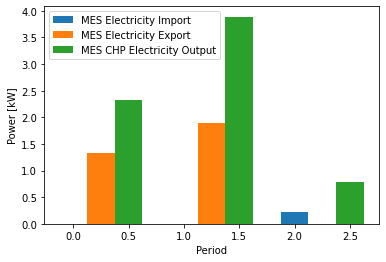

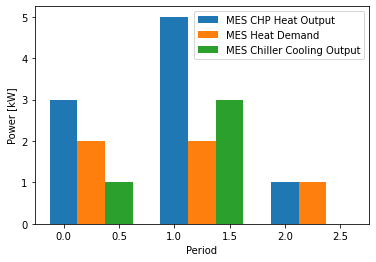

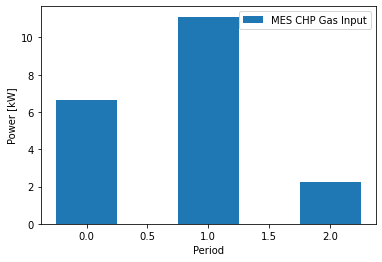

Costs: 1.02 (£)


In [31]:
model = pyo.ConcreteModel()
model.Set_Vectors = ['Electricity', 'Heat', 'Cooling', 'Gas']
model.dt = 1

model.Name = 'MES'
model.MES_Set_DER = ['CHP', 'Chiller']
model.MES_CHP = {
    'Capacity': 5,
    'Vector': 'Heat',
    'Efficiency': [0.35, 0.45],
    'Input': ['Gas', 'Gas'],
    'Output': ['Electricity', 'Heat']
}
model.MES_Chiller = {
    'Capacity': 5,
    'Vector': 'Cooling',
    'Efficiency': [1],
    'Input': ['Heat'],
    'Output': ['Cooling']
}

model.MES_Electricity_Demand = [1, 2, 1]  # (kW)
model.MES_Heat_Demand = [2, 2, 1]  # (kW)
model.MES_Cooling_Demand = [1, 3, 0]  # (kW)

model.MES_Electricity_Import_Price = [0.15, 0.20, 0.25]  # (£/kWh)
model.MES_Electricity_Export_Price = [0.01, 0.01, 0.01]  # (£/kWh)
model.MES_Gas_Import_Price = [0.05, 0.05, 0.05]  # (£/kWh)

# Build and solve model
result=build_MES(model)

# Visualize
Fig_Names = ['MES_Electricity_Import', 'MES_Electricity_Export', 'MES_CHP_Electricity_Output']
plot_MES(model, Fig_Names)
Fig_Names = ['MES_CHP_Heat_Output', 'MES_Heat_Demand', 'MES_Chiller_Cooling_Output']
plot_MES(model, Fig_Names)
Fig_Names = ['MES_CHP_Gas_Input']
plot_MES(model, Fig_Names)
sankey_MES(model, 'MES with cogeneration')
print('Costs: %.2f'%model.Objective_Function.expr(), '(£)')

[Back to top](#List-of-contents)